In [58]:
import pandas as pd
import matplotlib.pyplot as plt

In [107]:
#loading in county and census data and sorting for NC
county_data = pd.read_csv("us-counties-2021.csv")

# Prepping census data to be merged
white = pd.read_excel("census data.xlsx")
white2 = white[['county', 'pct_white']]

del white

white2['pct_white'] = 1 - white2['pct_white']
white2 = white2.rename(columns = {'pct_white': 'Minority_pct'})
white2['Minority_pct'] = round(white2['Minority_pct'], 4)


census = pd.read_csv("County_totals2022.csv")
census = census.drop(census.columns[[1, 2, 4]], axis = 1)
census.columns.values[1] = 'Population'
census.columns.values[0] = 'county'
census = census.drop(census.index[-1])

#Population Density Data

data = {
    'county': [
        'Alamance', 'Alexander', 'Alleghany', 'Anson', 'Ashe', 'Avery', 'Beaufort', 'Bertie', 'Bladen',
        'Brunswick', 'Buncombe', 'Burke', 'Cabarrus', 'Caldwell', 'Camden', 'Carteret', 'Caswell', 'Catawba',
        'Chatham', 'Cherokee', 'Chowan', 'Clay', 'Cleveland', 'Columbus', 'Craven', 'Cumberland', 'Currituck',
        'Dare', 'Davidson', 'Davie', 'Duplin', 'Durham', 'Edgecombe', 'Forsyth', 'Franklin', 'Gaston', 'Gates',
        'Graham', 'Granville', 'Greene', 'Guilford', 'Halifax', 'Harnett', 'Haywood', 'Henderson', 'Hertford',
        'Hoke', 'Hyde', 'Iredell', 'Jackson', 'Johnston', 'Jones', 'Lee', 'Lenoir', 'Lincoln', 'Macon', 'Madison',
        'Martin', 'McDowell', 'Mecklenburg', 'Mitchell', 'Montgomery', 'Moore', 'Nash', 'New Hanover', 'Northampton', 'Onslow',
        'Orange', 'Pamlico', 'Pasquotank', 'Pender', 'Perquimans', 'Person', 'Pitt', 'Polk', 'Randolph', 'Richmond',
        'Robeson', 'Rockingham', 'Rowan', 'Rutherford', 'Sampson', 'Scotland', 'Stanly', 'Stokes', 'Surry', 'Swain',
        'Transylvania', 'Tyrrell', 'Union', 'Vance', 'Wake', 'Warren', 'Washington', 'Watauga', 'Wayne', 'Wilkes',
        'Wilson', 'Yadkin', 'Yancey'
    ],
    'population_density_per_sq_mile': [
        404.8, 140.2, 46.4, 41.5, 62.3, 72.0, 53.6, 25.7, 33.8, 160.8, 410.4, 173.0, 625.1, 170.9, 43.1, 133.3,
        53.5, 400.2, 111.9, 63.2, 79.4, 51.6, 214.4, 54.0, 142.5, 512.9, 107.3, 96.3, 305.4, 162.0, 59.8, 1133.7,
        96.7, 938.1, 139.4, 640.7, 30.8, 27.5, 114.6, 76.7, 838.0, 67.2, 224.5, 112.2, 311.8, 61.0, 133.5, 7.5,
        325.0, 87.8, 272.7, 19.5, 248.1, 138.1, 293.4, 71.8, 47.1, 48.3, 101.3, 2130.4, 67.4, 52.4, 142.9, 175.7,
        1174.0, 32.6, 268.4, 374.0, 36.5, 178.8, 69.1, 52.6, 99.7, 261.0, 81.3, 184.3, 90.7, 123.0, 161.0, 287.1,
        114.0, 62.4, 107.1, 158.2, 99.1, 134.0, 26.8, 87.2, 8.3, 376.6, 168.7, 1353.3, 43.4, 31.8, 173.1, 211.8,
        87.5, 214.3, 111.1, 59.1
        ]
}

popdens = pd.DataFrame(data)
popdens.columns.values[1] = 'pop_dens'
popdens = popdens.sort_values(by='county').reset_index(drop=True)
print(popdens)


#Sorting the data by State
nc_cd = county_data.query('state == "North Carolina"')

del county_data

#Merging the two datasets together and setting date formats
nc_cd = pd.merge(nc_cd, census, on = 'county', how = 'left')

nc_cd['Population'] = pd.to_numeric(nc_cd['Population'].str.replace(',', ''), errors='coerce')

nc_cd['date'] = pd.to_datetime(nc_cd['date'], format = '%Y-%m-%d')

# # Date range
# start_date = '2021-07-01'
# end_date = '2021-12-02'

# nc_cd = nc_cd[(nc_cd['date'] >= start_date) & (nc_cd['date'] <= end_date)]

# Cases and death proportion variables
nc_cd['casesprop'] = round(nc_cd['cases']/nc_cd['Population'], 4)
nc_cd['deathsprop'] = round(nc_cd['deaths']/nc_cd['Population'], 4)

# Daily and weekly for cases and deaths
nc_cd['dailycase'] = nc_cd.groupby('county')['cases'].diff().fillna(0)

nc_cd['weeklycase'] = nc_cd.groupby('county')['cases'].diff(periods=7).fillna(0)

nc_cd['dailydeath'] = nc_cd.groupby('county')['deaths'].diff().fillna(0)

nc_cd['weeklydeath'] = nc_cd.groupby('county')['deaths'].diff(periods=7).fillna(0)

nc_cd['weeklyper100k'] = round(nc_cd['weeklycase']/(nc_cd['Population']/100000), 2)

def transmission_level(weeklyper100k):
        if 0 <= weeklyper100k < 10:
            return 'Low'
        elif 10 <= weeklyper100k < 50:
            return 'Moderate'
        elif 50 <= weeklyper100k < 100:
            return 'Substantial'
        elif 100 <= weeklyper100k:
            return 'High'
        else:
            return 'Error'
        
nc_cd['tranlevel'] = nc_cd['weeklyper100k'].apply(transmission_level)

nc_cd = pd.merge(nc_cd, popdens, on = 'county', how = 'left')

nc_cd = pd.merge(nc_cd, white2, on = 'county', how = 'left')
 
# nc_cd2 = nc_cd.drop(nc_cd[nc_cd['tranlevel'] == 'Error'].index)


# Sorting the counties by region for base visualizations
Central_reg = ['Anson', 'Cabarrus', 'Gaston', 'Lincoln', 'Mecklenburg', 'Stanly', 'Union']

Coastal_reg = ['Beaufort', 'Bertie', 'Bladen', 'Brunswick', 'Camden', 'Carteret', 'Chowan',
               'Columbus', 'Craven', 'Currituck', 'Dare', 'Duplin', 'Edgecombe', 'Gates',
               'Greene', 'Halifax', 'Hertford', 'Hyde', 'Johnston', 'Jones', 'Lenoir',
               'Martin', 'Nash', 'New Hanover', 'Onslow', 'Pamlico', 'Pasquotank', 'Pender',
               'Perquimans', 'Pitt', 'Robeson', 'Sampson', 'Tyrrell', 'Washington', 'Wayne',
               'Wilson']

Eastern_reg = ['Caswell', 'Chatham', 'Cumberland', 'Durham', 'Franklin', 'Granville',
               'Harnett', 'Hoke', 'Lee', 'Montgomery', 'Moore', 'Northampton', 'Orange',
               'Person', 'Richmond', 'Scotland', 'Vance', 'Wake', 'Warren']

Northern_reg = ['Alamance', 'Alexander', 'Alleghany', 'Ashe', 'Caldwell', 'Catawba',
                'Davidson', 'Davie', 'Forsyth', 'Guilford', 'Iredell', 'Randolph',
                'Rockingham', 'Rowan', 'Stokes', 'Surry', 'Yadkin', 'Watauga', 'Wilkes']

Western_reg = ['Avery', 'Buncombe', 'Burke', 'Cherokee', 'Clay', 'Cleveland', 'Graham',
               'Haywood', 'Henderson', 'Jackson', 'Macon', 'Madison', 'McDowell', 'Mitchell',
               'Polk', 'Rutherford', 'Swain', 'Transylvania', 'Yancey']

# Assign regions to create a region dataset
def assign_region(county):
    if county in Central_reg:
        return 'Central'
    elif county in Coastal_reg:
        return 'Coastal'
    elif county in Eastern_reg:
        return 'Eastern'
    elif county in Northern_reg:
        return 'Northern'
    elif county in Western_reg:
        return 'Western'
    else:
        return 'Error'

nc_cd2['region'] = nc_cd2['county'].apply(assign_region)
print(nc_cd2['region'].value_counts())

nc_cd2.to_csv('countyall.csv')

data = nc_cd2

       county  pop_dens
0    Alamance     404.8
1   Alexander     140.2
2   Alleghany      46.4
3       Anson      41.5
4        Ashe      62.3
..        ...       ...
95      Wayne     211.8
96     Wilkes      87.5
97     Wilson     214.3
98     Yadkin     111.1
99     Yancey      59.1

[100 rows x 2 columns]
region
Coastal     5564
Northern    2944
Eastern     2938
Western     2930
Central     1085
Name: count, dtype: int64


In [108]:
#data = pd.read_csv("countyall.csv")
census = pd.read_excel("census data.xlsx")
#data['pop_dens'] = data["population_density_per_sq_mile"]
data = pd.merge(data, census, on="county", how="inner")
data.head()

,date,county,state,fips,cases,deaths,Population,casesprop,deathsprop,dailycase,...,pop_hislat,pop_nonwhite,med_hhi,poverty_level,voter_turnout,acs_education,crime_per_100k,rucc,rucc_descript,rural_metro
0,2021-07-01,Alamance,North Carolina,37001.0,19035,289.0,175029.0,0.1088,0.0017,0.0,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro
1,2021-07-02,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,7.0,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro
2,2021-07-03,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,0.0,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro
3,2021-07-04,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,0.0,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro
4,2021-07-05,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,0.0,...,0.1441,0.3825,55078,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro


In [109]:
def categorize_hotspot(cases):
    if cases >= 50:
        return True
    else:
        return False

data['Hotspot'] = data['weeklyper100k'].apply(categorize_hotspot)

In [112]:
data.sort_values(by=['county', 'date'], inplace=True)

# Shift the 'Hotspot' column by 14 days to create a new column indicating hotspot status in two weeks
data['Hotspot_in_2_weeks'] = data.groupby('county')['Hotspot'].shift(-14)
data_grouped = data.groupby('county')['Hotspot'].sum().reset_index(name='Num_Hotspot')
print(data_grouped)

def categorize_hotspot(cases):
    if cases >= 100:
        return True
    else:
        return False

data['Hotspot_2'] = data['weeklyper100k'].apply(categorize_hotspot)

       county  Num_Hotspot
0    Alamance          136
1   Alexander          137
2   Alleghany          123
3       Anson          138
4        Ashe          130
..        ...          ...
95      Wayne          148
96     Wilkes          137
97     Wilson          140
98     Yadkin          140
99     Yancey          129

[100 rows x 2 columns]


In [113]:
# Date range
start_date = '2021-07-01'
end_date = '2021-12-02'

data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
data

,date,county,state,fips,cases,deaths,Population,casesprop,deathsprop,dailycase,...,poverty_level,voter_turnout,acs_education,crime_per_100k,rucc,rucc_descript,rural_metro,Hotspot,Hotspot_in_2_weeks,Hotspot_2
0,2021-07-01,Alamance,North Carolina,37001.0,19035,289.0,175029.0,0.1088,0.0017,0.0,...,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,False,False
1,2021-07-02,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,7.0,...,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,False,False
2,2021-07-03,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,0.0,...,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,False,False
3,2021-07-04,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,0.0,...,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,False,False
4,2021-07-05,Alamance,North Carolina,37001.0,19042,289.0,175029.0,0.1088,0.0017,0.0,...,0.144,0.78,0.253,3065.6,3,Metro - Counties in metro areas of fewer than ...,Metro,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15456,2021-11-28,Yancey,North Carolina,37199.0,2996,35.0,18320.0,0.1635,0.0019,0.0,...,0.147,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,NaN,True
15457,2021-11-29,Yancey,North Carolina,37199.0,3020,35.0,18320.0,0.1648,0.0019,24.0,...,0.147,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,NaN,True
15458,2021-11-30,Yancey,North Carolina,37199.0,3024,35.0,18320.0,0.1651,0.0019,4.0,...,0.147,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,NaN,True
15459,2021-12-01,Yancey,North Carolina,37199.0,3030,35.0,18320.0,0.1654,0.0019,6.0,...,0.147,0.81,0.203,557.0,8,"Nonmetro - Completely rural or less than 2,500...",Rural,True,NaN,True


Text(0, 0.5, 'Frequency')

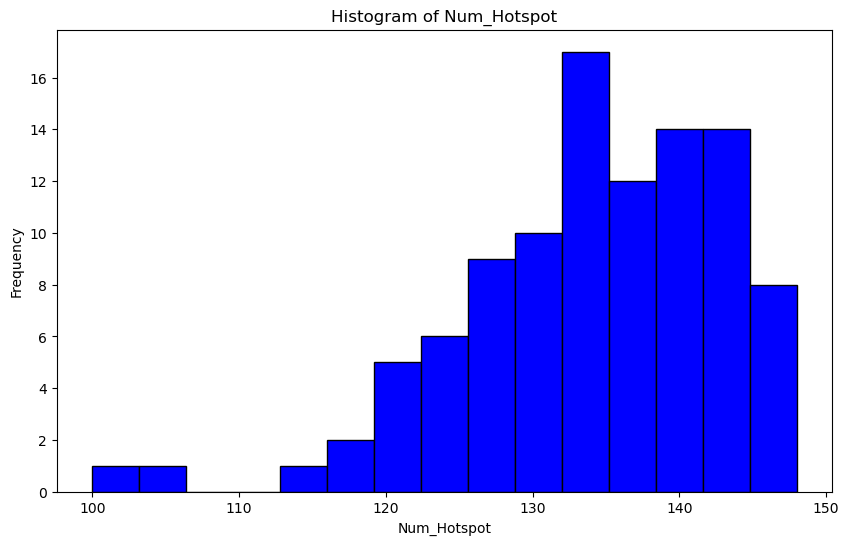

In [114]:
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(data_grouped['Num_Hotspot'], bins=15, color='blue', edgecolor='black')  # Plot histogram
plt.title('Histogram of Num_Hotspot')  # Add a title
plt.xlabel('Num_Hotspot')  # Label for the X-axis
plt.ylabel('Frequency') 

In [115]:
data_grouped.sort_values("Num_Hotspot")

,county,Num_Hotspot
45,Hertford,100
65,Northampton,106
47,Hyde,113
55,Macon,117
93,Washington,118
...,...,...
27,Dare,147
25,Cumberland,148
95,Wayne,148
46,Hoke,148


Text(0, 0.5, 'Frequency')

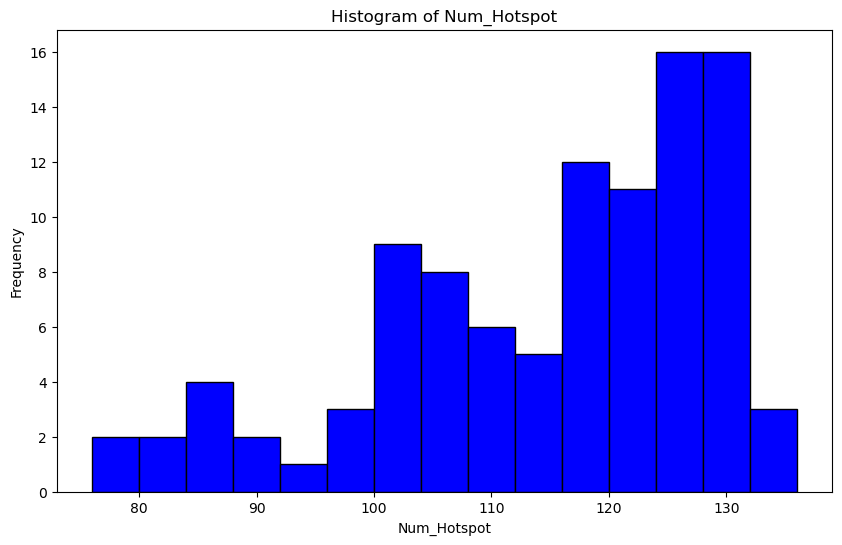

In [116]:
data_grouped_2 = data.groupby('county')['Hotspot_2'].sum().reset_index(name='Num_Hotspot')

plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(data_grouped_2['Num_Hotspot'], bins=15, color='blue', edgecolor='black')  # Plot histogram
plt.title('Histogram of Num_Hotspot')  # Add a title
plt.xlabel('Num_Hotspot')  # Label for the X-axis
plt.ylabel('Frequency') 

In [117]:
data_full = data

data_full.to_csv("data_full.csv")

In [118]:
# choosing categories for analysis

data_analysis = data[["county", "date", "pop_dens", "Population", "cases",'weeklyper100k', "Hotspot"]]
data_analysis = data_analysis.loc[data_analysis['county'].isin(['Lincoln','Wake'])]
data_analysis

,county,date,pop_dens,Population,cases,weeklyper100k,Hotspot
8353,Lincoln,2021-07-01,293.4,88742.0,10286,0.00,False
8354,Lincoln,2021-07-02,293.4,88742.0,10289,0.00,False
8355,Lincoln,2021-07-03,293.4,88742.0,10289,0.00,False
8356,Lincoln,2021-07-04,293.4,88742.0,10289,0.00,False
8357,Lincoln,2021-07-05,293.4,88742.0,10289,0.00,False
...,...,...,...,...,...,...,...
14222,Wake,2021-11-26,1353.3,1154170.0,135430,83.09,True
14223,Wake,2021-11-27,1353.3,1154170.0,135430,83.09,True
14224,Wake,2021-11-28,1353.3,1154170.0,135430,83.09,True
14225,Wake,2021-11-29,1353.3,1154170.0,136106,105.96,True


In [119]:
data_analysis.to_csv("analysis_data_small.csv")
#data.to_csv("data_large.csv")